In [1]:
# import source code
import sys
sys.path.append("..")

import src.data.datasetloaders as dl
import src.analysis.analyser as anlyz

import os
import sklearn
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from types import SimpleNamespace
from pprint import pprint
from collections import defaultdict


/Users/dr84sy/.local/share/mamba/envs/kgs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataframes(result_dir):
    dataframes = []
    for dirpath, dirnames, filenames in os.walk(result_dir):
        for filename in filenames:
            if not filename.endswith(".json"):
                continue
            if "full" in filename:
                continue
            
            # process
            print(f"Reading {dirpath}/{filename}")
            
            df = pl.read_json(os.path.join(dirpath, filename), infer_schema_length=1000000)
            
            # if translations in columns
            if "translation" in df.columns:
                # remove the translation column
                df = df.drop("translation")
            
            
            # get the name of the file without the extension
            name = os.path.splitext(filename)[0]
            name = name.replace("llm_eval_", "")
            name = "_".join(name.split("_")[:-1])
            
            lang = "eng"
            if "deu" in name:
                lang = "deu"
            elif "fra" in name:
                lang = "fra"
            elif "spa" in name:
                lang = "spa"
            elif "ita" in name:
                lang = "ita"
            elif "por" in name:
                lang = "por"
            
            if lang in name:
                name = name.replace(f"_{lang}", "")
            
            task = "G-RAG" if "grag" in filename else "QA"
            # add the dataframe to a dictionary
            dataframes.append((name, lang, task, df))
    return dataframes

result_dir = "main_results"
dfs = get_dataframes(result_dir)
print(f"Found {len(dfs)} dataframes")


Reading main_results/eng/20250504-171525_llama3_70bn/data/llm_eval_meta-llama-llama-3.3-70b-instruct_grag.json
Reading main_results/eng/20250504-171525_llama3_70bn/data/llm_eval_meta-llama-llama-3.3-70b-instruct_qa.json
Reading main_results/eng/gemma2/data/llm_eval_google-gemini-2.0-flash-001_grag.json
Reading main_results/eng/gemma2/data/llm_eval_google-gemini-2.0-flash-001_qa.json
Reading main_results/eng/gpt4oMini/data/llm_eval_openai-gpt-4o-mini_grag.json
Reading main_results/eng/gpt4oMini/data/llm_eval_openai-gpt-4o-mini_qa.json
Reading main_results/fra/20250505-212405_fra_gpt/data/llm_eval_openai-gpt-4o-mini_fra_grag.json
Reading main_results/fra/20250505-212405_fra_gpt/data/llm_eval_openai-gpt-4o-mini_fra_qa.json
Reading main_results/fra/20250505-212410_fra_gemini/data/llm_eval_google-gemini-2.0-flash-001_fra_grag.json
Reading main_results/fra/20250505-212410_fra_gemini/data/llm_eval_google-gemini-2.0-flash-001_fra_qa.json
Reading main_results/fra/20250507-145613_fra_llama/data/

In [3]:
# sort dfs first by languages [eng, de, es, fr, it, pt] and then by name
dfs = sorted(dfs, key=lambda x: (["eng", "deu", "fra", "ita", "spa", "por"].index(x[1]), x[0]))

In [4]:
results_df = pl.DataFrame()
for name, lang, task, df in dfs:
    print(df['source_dataset'].value_counts())
    # add the name of the file to the dataframe
    df = df.with_columns(pl.lit(name).alias("name"))
    # add the language to the dataframe
    df = df.with_columns(pl.lit(lang).alias("lang"))
    # add the task to the dataframe
    df = df.with_columns(pl.lit(task).alias("task"))
    
    if 'translation' in df.columns:
        df = df.drop('translation')
    
    # add the dataframe to the results dataframe
    print(f"Adding {name} ({lang}) to results dataframe")
    results_df = pl.concat([results_df, df], how="vertical")

shape: (7, 2)
┌────────────────┬───────┐
│ source_dataset ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ simpleqa       ┆ 3300  │
│ defan          ┆ 9969  │
│ halubench      ┆ 626   │
│ felm           ┆ 73    │
│ halueval       ┆ 11398 │
│ tqa_gen        ┆ 193   │
│ shroom2024     ┆ 346   │
└────────────────┴───────┘
Adding google-gemini-2.0-flash-001 (eng) to results dataframe
shape: (7, 2)
┌────────────────┬───────┐
│ source_dataset ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ halueval       ┆ 11398 │
│ defan          ┆ 9969  │
│ felm           ┆ 73    │
│ shroom2024     ┆ 346   │
│ simpleqa       ┆ 3300  │
│ tqa_gen        ┆ 193   │
│ halubench      ┆ 626   │
└────────────────┴───────┘
Adding google-gemini-2.0-flash-001 (eng) to results dataframe
shape: (7, 2)
┌────────────────┬───────┐
│ source_dataset ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪══════

In [5]:
output = pl.DataFrame()
path_counts = defaultdict(list)
for i in results_df.group_by(['domain', 'source_dataset'], maintain_order=True):
    domain = i[0][0]
    source_dataset = i[0][1]
    
    grouped_df = i[1]
    
    entry = []
    
    for j in grouped_df.group_by(['task', 'name'], maintain_order=True):
        task = j[0][0]
        name = j[0][1]
        grouped_df2 = j[1]
        
        # get the mean of the score
        mean_score = round(grouped_df2['sem_score'].mean(), 3)
        
        # get the std of the score
        std_score = grouped_df2['sem_score'].std()
        
        
        dp_p = len(grouped_df2) / 6
        
        # get unique IDs where last underscore is removed
        unique_ids = grouped_df2['id'].unique().to_list()
        unique_ids = [i.split("_")[:-1] for i in unique_ids]
        unique_ids = ["_".join(i) for i in unique_ids]
        unique_ids = list(set(unique_ids))
        dp_q = len(unique_ids)
        
        # add the mean and std to the dataframe
        entry.append((f"{source_dataset} ({domain})_p={dp_p} q={dp_q}", f"{task}_{name}_mean", mean_score))

    output = pl.concat([
        output, 
        pl.DataFrame(entry, schema={"domain": pl.Utf8, "task_name": pl.Utf8, "sem_score": pl.Float64})])
    
# make task name a column and sem_score the value
output = output.pivot(index="domain", columns="task_name", values="sem_score")



/var/folders/jc/byg_r3zn38lc7jrwxbmgfk_c0000gp/T/ipykernel_96983/2926915031.py:37: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  pl.DataFrame(entry, schema={"domain": pl.Utf8, "task_name": pl.Utf8, "sem_score": pl.Float64})])
/var/folders/jc/byg_r3zn38lc7jrwxbmgfk_c0000gp/T/ipykernel_96983/2926915031.py:40: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  output = output.pivot(index="domain", columns="task_name", values="sem_score")


In [6]:
# add deltas
for i in range(1, len(output.columns[1:]), 2):
    # get the name of the column
    col_name = output.columns[i]
    
    # get the name of the previous column
    prev_col_name = output.columns[i+1]
    
    # get the delta
    delta = output[col_name] - output[prev_col_name]
    
    # add the delta to the dataframe
    output_w_stats = output.with_columns(delta.alias(col_name.replace("_mean", "_delta")))
    

output_w_stats = output_w_stats.with_columns([
    pl.col("domain").str.extract(r"p=(\d+)", 1).cast(pl.Int64).alias("number_of_paths"),
    pl.col("domain").str.extract(r"q=(\d+)", 1).cast(pl.Int64).alias("number_of_questions"),
    pl.col("domain").str.replace(r'[_ ]p=\d+(\.\d+)? ?q=\d+(\.\d+)?', "").alias("domain")
])

print(output_w_stats)
os.makedirs("output", exist_ok=True)
output_w_stats.write_csv("output/baseline_results_per_domain.csv")

shape: (48, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ domain    ┆ G-RAG_goo ┆ QA_google ┆ G-RAG_met ┆ … ┆ QA_openai ┆ G-RAG_ope ┆ number_of ┆ number_o │
│ ---       ┆ gle-gemin ┆ -gemini-2 ┆ a-llama-l ┆   ┆ -gpt-4o-m ┆ nai-gpt-4 ┆ _paths    ┆ f_questi │
│ str       ┆ i-2.0-fla ┆ .0-flash- ┆ lama-3.3- ┆   ┆ ini_mean  ┆ o-mini_de ┆ ---       ┆ ons      │
│           ┆ sh-…      ┆ 001…      ┆ 70b…      ┆   ┆ ---       ┆ lta       ┆ i64       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ ---       ┆           ┆ i64      │
│           ┆ f64       ┆ f64       ┆ f64       ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ tqa_gen   ┆ 0.611     ┆ 0.887     ┆ 0.754     ┆ … ┆ 0.82      ┆ 0.051     ┆ 19        ┆ 7        │
│ (misconce ┆           ┆           ┆           ┆   ┆           ┆          

In [7]:
print(output['domain'].unique().count())

48


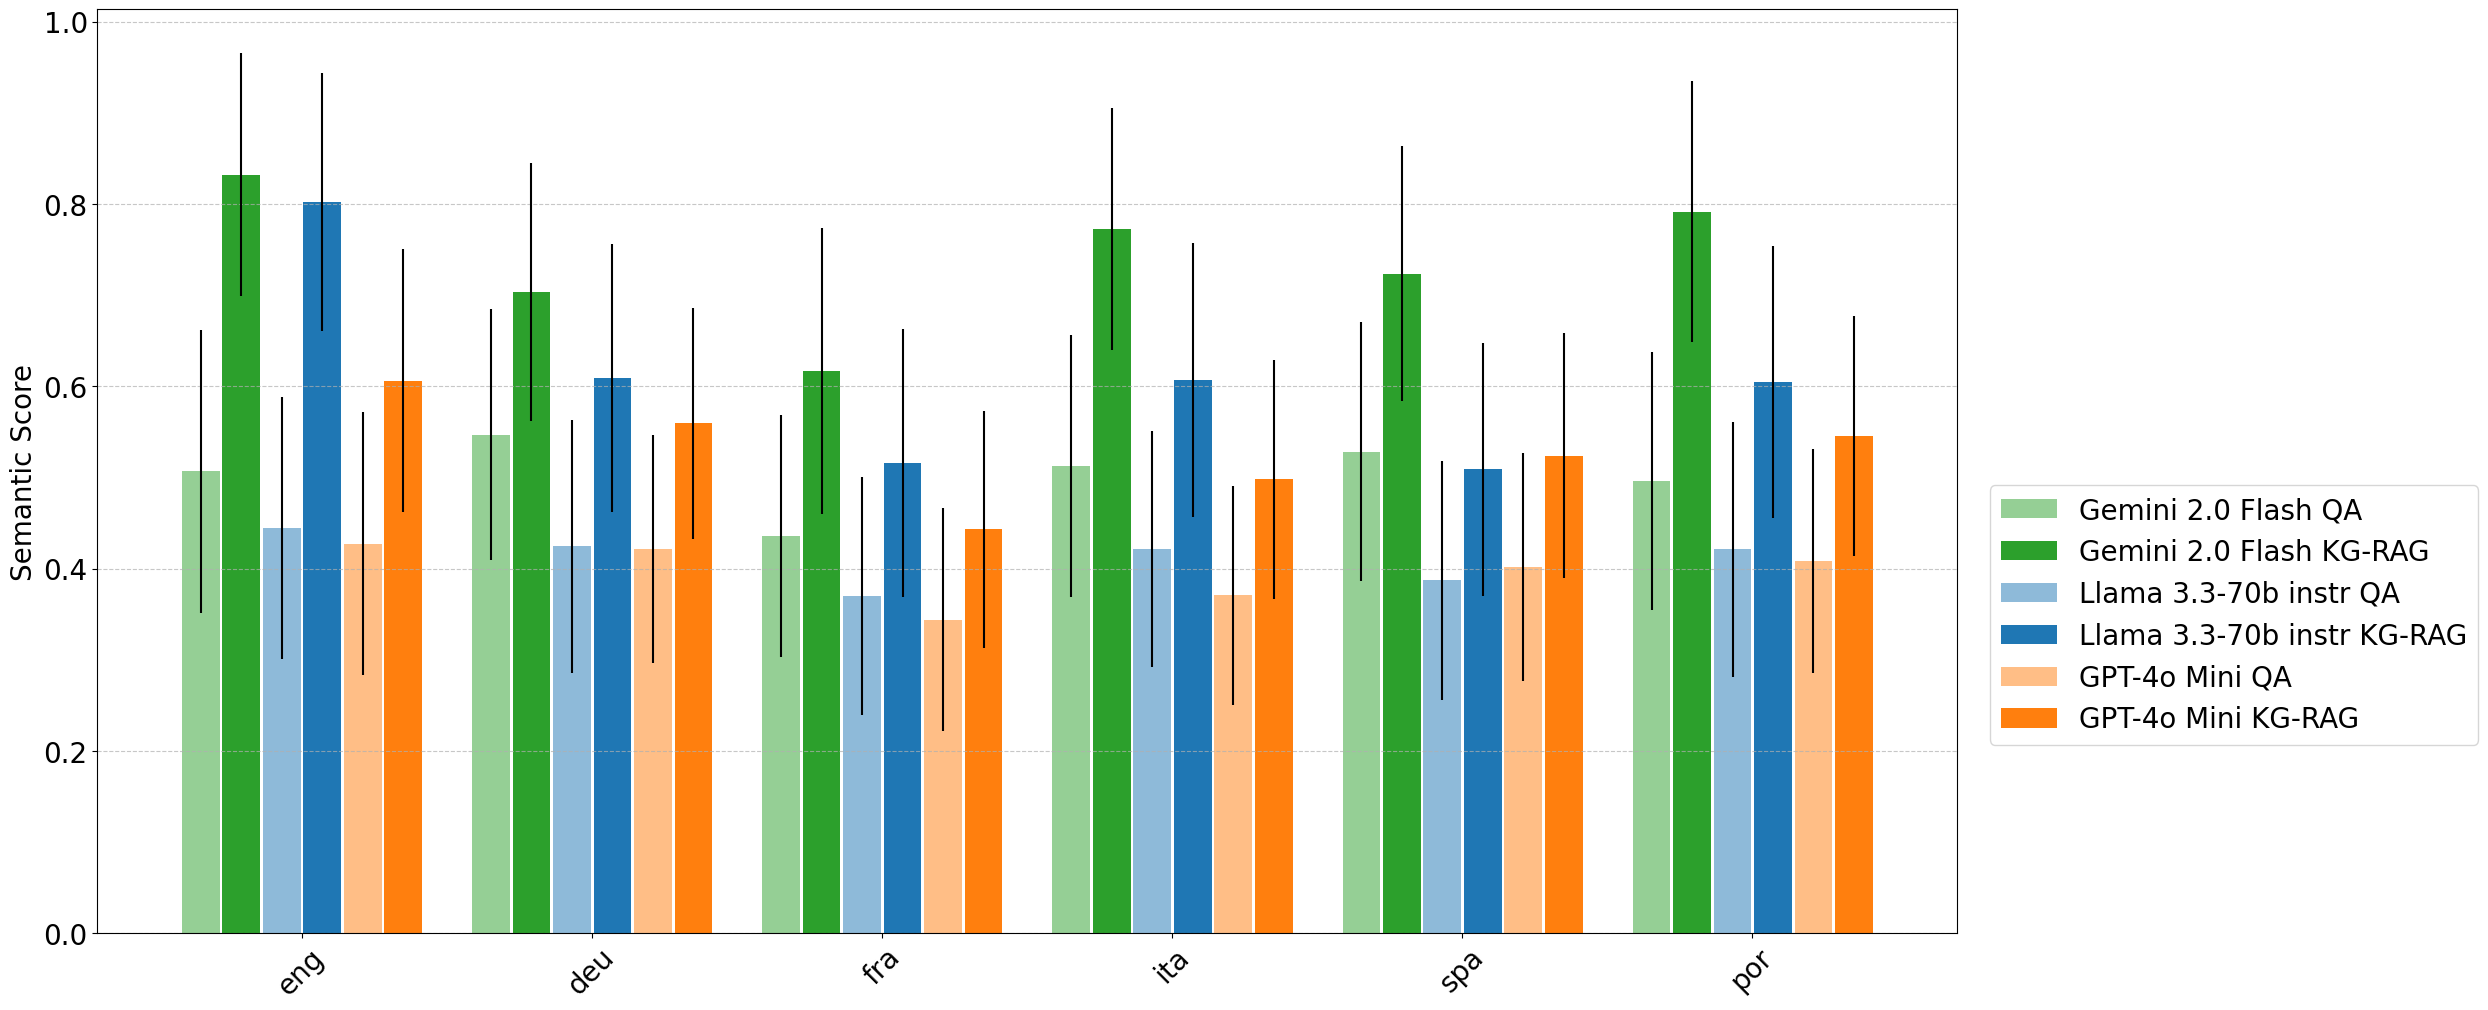

<Figure size 640x480 with 0 Axes>

In [8]:
# regex "_XXX_XXXX"
matplotlib_colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
colors = {i:matplotlib_colors.pop(0) for i in results_df['name'].unique().to_numpy()}

x = np.arange(len(results_df['lang'].unique()))  # the label locations
lang_positions = {k: v for v, k in enumerate(results_df['lang'].unique(maintain_order=True))}
width = 1.5  # the width of the bars
multiplier = 0

# Assuming 6 bars per language group
num_bars_per_group = 7
bar_width = 0.8 / num_bars_per_group  # Seaborn uses 0.8 default width

positions = []
for i, lang in enumerate(lang_positions):
    group_center = (0.44 + i) * 10.75  # Center of group
    positions.append(group_center)

fig, ax = plt.subplots(figsize=(24, 12))
res = pl.DataFrame()
for i in results_df.group_by(["lang"], maintain_order=True):
    lang = i[0][0]
    df = i[1]
    micro_multiplier = 1
    for j in df.group_by(["name"], maintain_order=True):
        name = j[0][0]
        df2 = j[1]
        
        qa_series = df2.filter(pl.col("task") == "QA")["sem_score"]
        grag_series = df2.filter(pl.col("task") == "G-RAG")["sem_score"]
        
        # Bar position for this group
        offset = width * multiplier
        pos = x[lang_positions[lang]] + offset

        # Average scores
        values = [qa_series, grag_series]
        task_labels = ['QA', 'KG-RAG']
        
        # Plot each bar individually (since grouped by task)
        for idx, value in enumerate(values):
            
            if "llama" in name:
                name_form = "Llama 3.3-70b instr"
            elif "gemini" in name:
                name_form = "Gemini 2.0 Flash"
            elif "gpt" in name:
                name_form = "GPT-4o Mini"
            
            
            ax.bar(
                x=pos + micro_multiplier + idx * width,
                height=value.mean(),
                yerr=value.std() / 2, 
                width=width - 0.1,
                label=f"{name_form} {task_labels[idx]}",  # Only add label once for legend
                color=colors[name],
                alpha=1 if task_labels[idx] == 'KG-RAG' else 0.5,
                
            )
        micro_multiplier += 3
    
    multiplier += 6.5

# Final plot setup
ax.set_ylabel('Semantic Score', fontsize=20)
ax.set_xticks(positions)  # Center x-ticks based on number of groups
ax.set_xticklabels(results_df['lang'].unique(maintain_order=True), fontsize=20)

# remove duplicate labels from legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.01, 0.5), fontsize=20)
# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# increase y axis font size
ax.tick_params(axis='y', labelsize=20)

# icrease font size


plt.xticks(rotation=45)
plt.show()
plt.savefig("output/semantic_score_averages.png", bbox_inches='tight', dpi=300)

    

# Preliminary Baselines

In [9]:
prelim_gpt_eval = pl.read_json("preliminary_baselines/gpt-gemini/20250502-101426_eval_gemini_rated_gpt4omini/data/llm_eval_google-gemini-2.0-flash-001_grag.json", infer_schema_length=1000000)
prelim_gemini_eval = pl.read_json("preliminary_baselines/gpt-gemini/20250501-125906_eval_gemini_rated_gemini/data/llm_eval_google-gemini-2.0-flash-001_grag.json", infer_schema_length=1000000)

# Step 1: Count occurrences per class
c = prelim_gpt_eval.group_by("judged_score").count().sort("count")
min_count = c[0, "count"]  # smallest class count

# Step 2: Sample min_count from each class
balanced_df = (
    prelim_gpt_eval
    .group_by("judged_score", maintain_order=True)
    .map_groups(lambda group: group.sample(n=min_count, with_replacement=False))
)
balanced_df['judged_score'].value_counts()

/var/folders/jc/byg_r3zn38lc7jrwxbmgfk_c0000gp/T/ipykernel_96983/903181188.py:5: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  c = prelim_gpt_eval.group_by("judged_score").count().sort("count")


judged_score,count
i64,u32
5,383
3,383
2,383
1,383
4,383


In [10]:
def get_correlation(df, name):
    sem_scores = df['sem_score']
    judged_scores = df['judged_score']
    
    
    corr = stats.pearsonr(sem_scores, judged_scores)
    print(f"Correlation for {name}: {corr}")
    return corr


stat_gpt_eval = get_correlation(prelim_gpt_eval, "GPT_Eval")
stat_gemini_eval = get_correlation(prelim_gemini_eval, "Gemini_Eval")

pl.DataFrame({"Path Judge Model": ["GPT 4o-Mini", "Gemini 2.0 Flash"], 
              "SemScore": [prelim_gpt_eval['sem_score'].mean(), prelim_gemini_eval['sem_score'].mean()],
              "Correlation": [stat_gpt_eval[0], stat_gemini_eval[0]]}).write_csv("output/pearson_correlation.csv")




Correlation for GPT_Eval: PearsonRResult(statistic=0.48527951859031637, pvalue=2.264332861712471e-167)
Correlation for Gemini_Eval: PearsonRResult(statistic=0.42957582128804517, pvalue=3.957414775228394e-124)


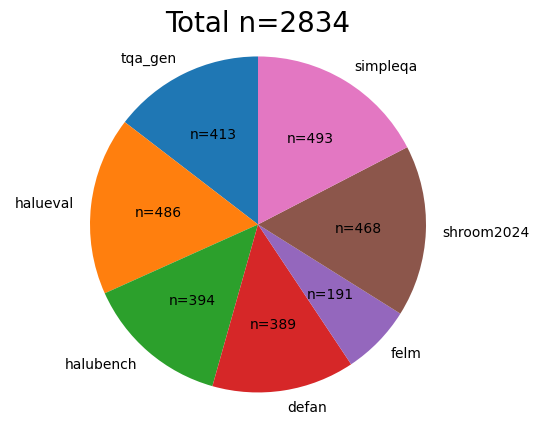

In [11]:
pie_df = prelim_gpt_eval['source_dataset'].value_counts()
src_dataset = pie_df['source_dataset']
counts = pie_df['count']

# plot pie chart
def absolute_value(val, sizes):
    import numpy as np
    a  = np.round(val/100.*sizes.sum(), 0)
    return f"n={int(a)}"

fig, ax = plt.subplots()
ax.pie(counts, labels=src_dataset, autopct=lambda x: absolute_value(x, counts), startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Total n={counts.sum()}", fontsize=20)
plt.savefig("output/prelim_baseline_distribution.png", bbox_inches='tight', dpi=300)